## Jaccard-based network evaluation
Large experiment with jaccard distance. Sample size is 9000 the rest is used for evaluation. For $\gamma$ values from 0 to 1.0
first a reference network is created, and subseqently data are diveded into 8 partitions, for each partition a network is created,
afterwards the partition networks are merged (one-shot). 



In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from appknn import lcl, vote
import seaborn as sns


sns.set_theme()

%matplotlib inline
%config InlineBackend.figure_format = 'retina'


In [2]:
def make_plot(colnames, alldata):
    plt.figure(figsize=(12,8))
    plt.title(f"Comparision of: {' '.join(colnames)}")
    for colname in colnames:
        plt.plot(alldata[f"{colname}_mer"], label=f"merged: {colname}")
        plt.plot(alldata[f"{colname}_ref"], label=f"reference: {colname}")
        
    plt.xlabel(r"$\gamma$")
    plt.legend();

In [3]:
#alldata = pd.read_csv('res/out.csv', index_col=0)
alldatajac = pd.read_csv('res/jaccards.csv', index_col=0)

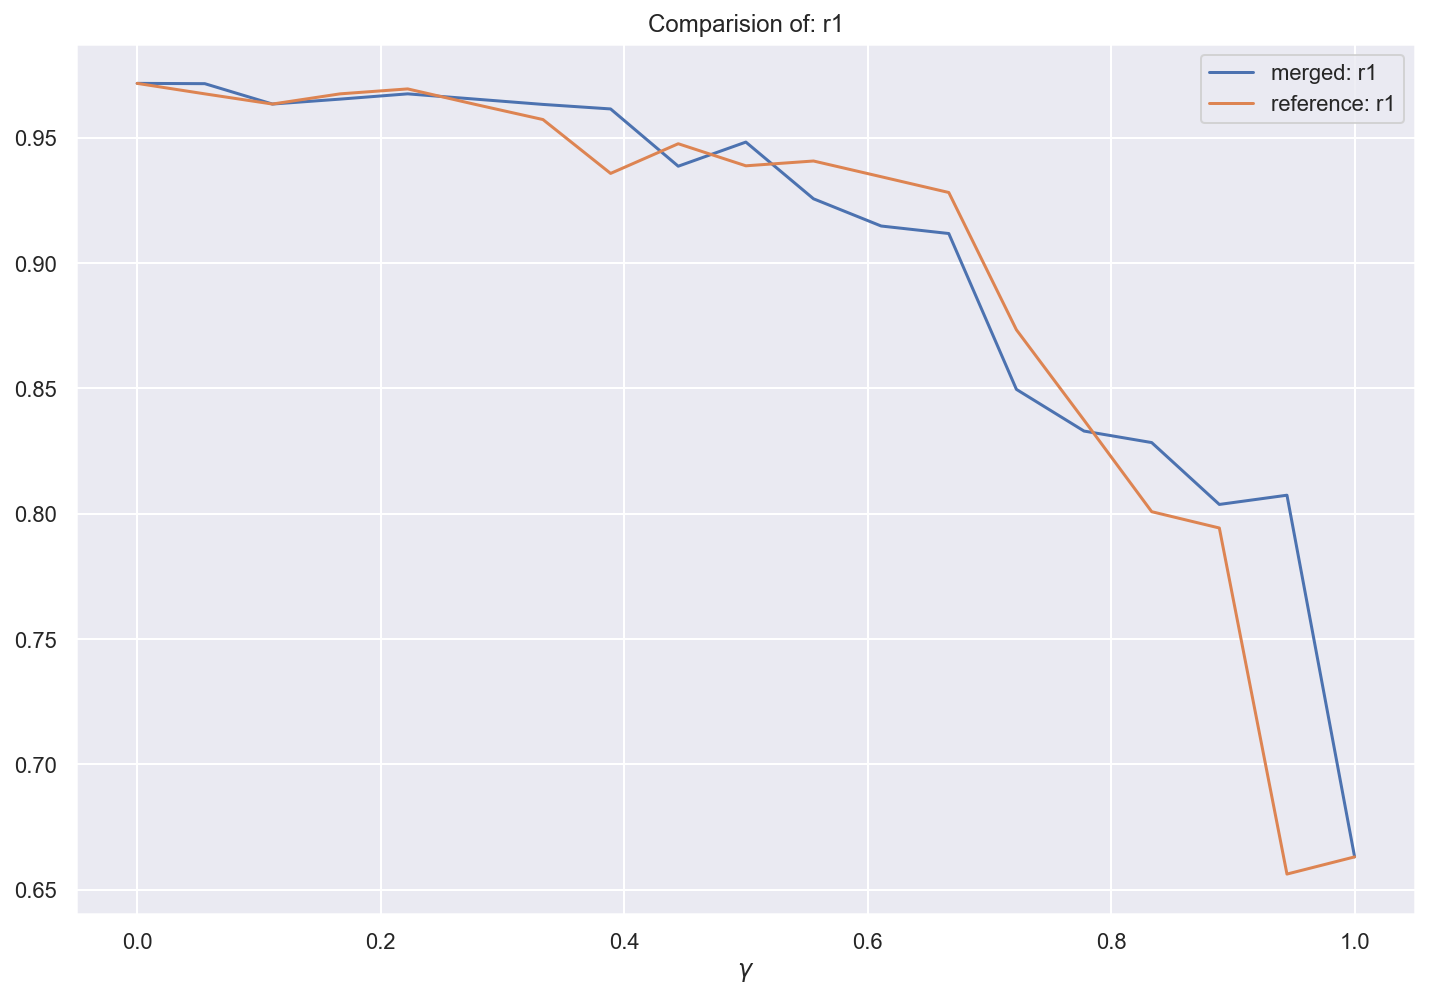

In [7]:
make_plot(["r1"], alldatajac)

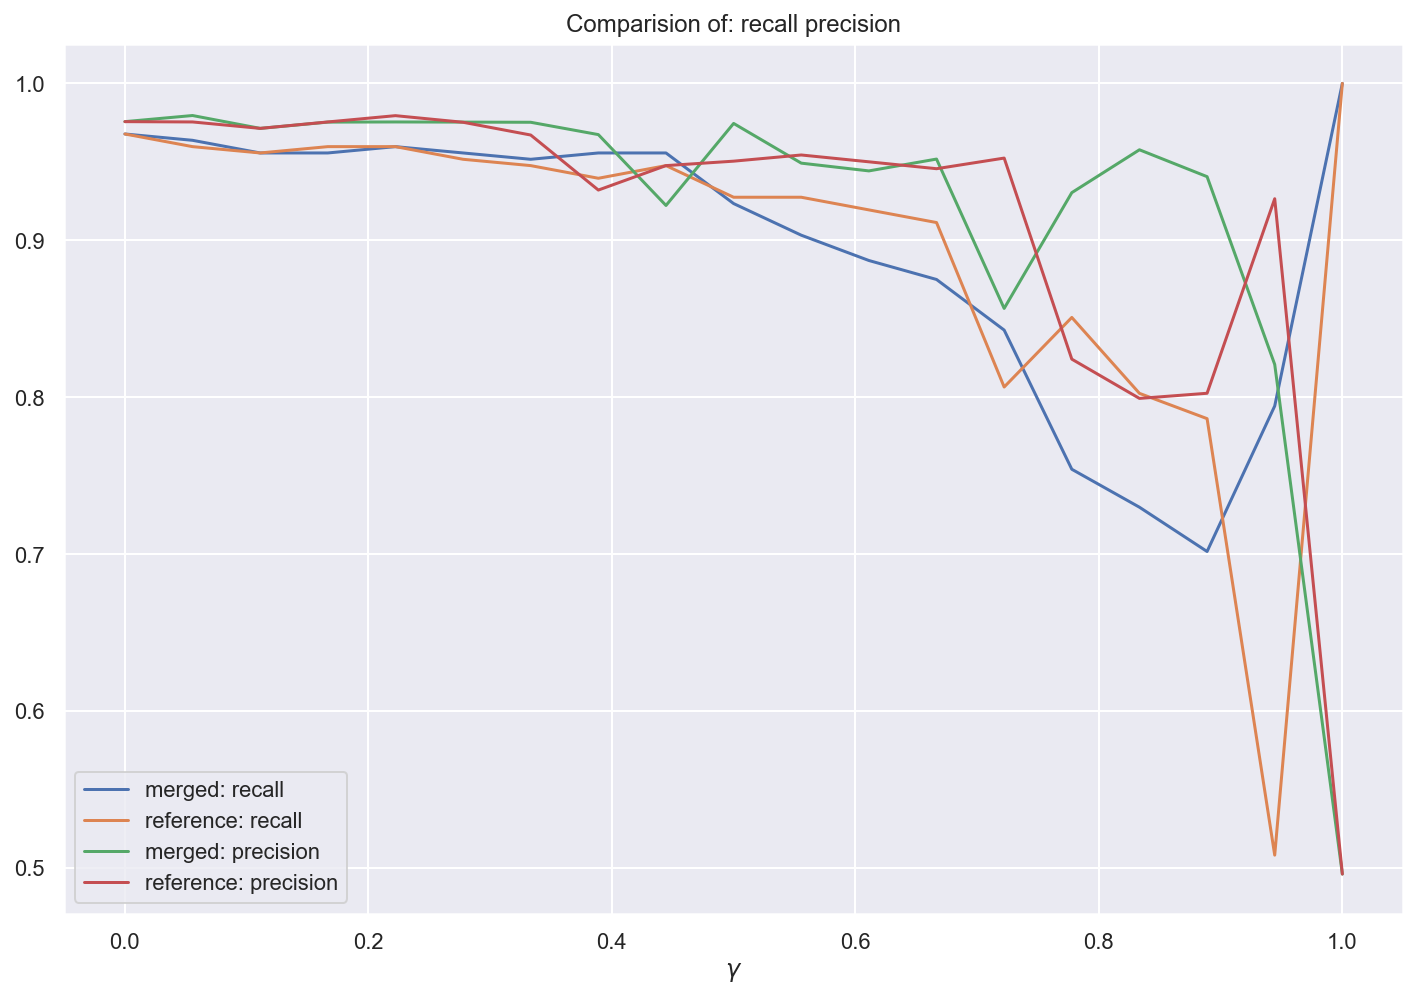

In [8]:
make_plot(["recall", "precision"], alldatajac)

In [9]:
with open('res/9503-jaccard-votingnets.pickle', 'rb') as f:
    nets = pickle.load(f)
    
def get_data():
    m = pd.read_csv('data/joined.csv', index_col='apn')
    m['nf'] = m['nf'].apply(eval)
    return m

m = get_data()
classifier = lambda x: lcl(x, m['ml'])

In [11]:
ref, mer = nets[0.0]
siz = sum(map(sum, ref.values()))
sm = sum(map(sum, mer.values()))
print(f"Overal number of votes in the network (==sample size) {siz} {sm}")

Overal number of votes in the network (==sample size) 9503 9503


In [12]:
alldatajac['comp_mer']  = alldatajac.anchors_mer / siz
alldatajac['comp_ref']  = alldatajac.anchors_ref / siz

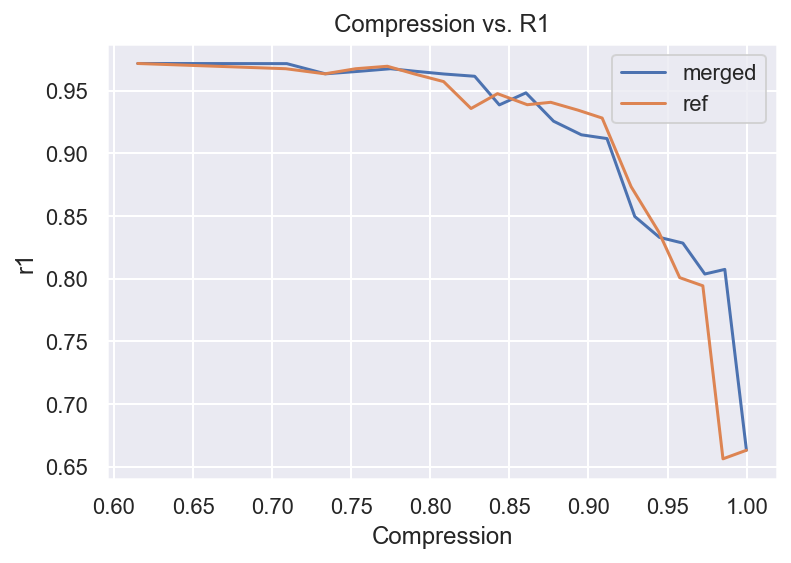

In [14]:
plt.title('Compression vs. R1')
plt.plot(1-alldatajac.comp_mer, alldatajac.r1_mer, label='merged')
plt.plot(1-alldatajac.comp_ref, alldatajac.r1_ref, label='ref')
plt.xlabel('Compression')
plt.ylabel('r1')
plt.legend();


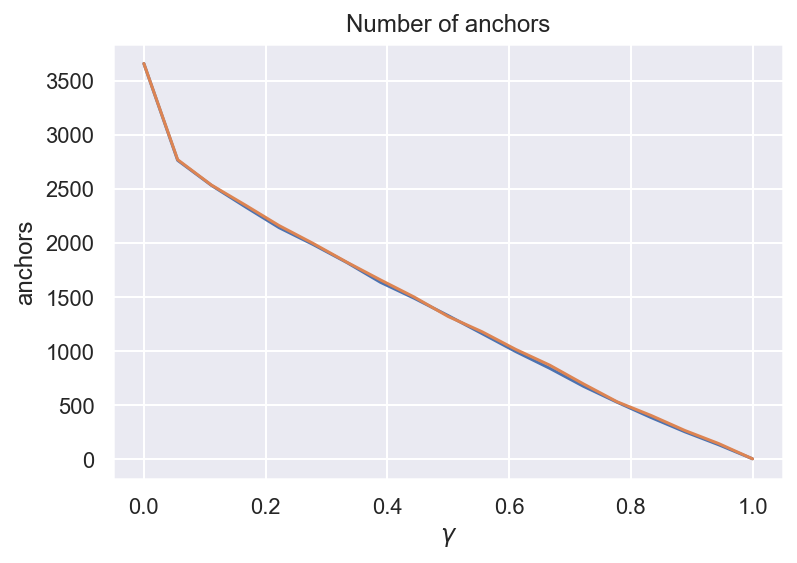

In [80]:
plt.title("Number of anchors")
plt.plot(alldatajac.anchors_mer, label='merged')
plt.plot(alldatajac.anchors_ref, label='ref')
plt.xlabel(r"$\gamma$")
plt.ylabel('anchors');

## Votes distribution

For each value of gamma, the amount of anchors with majority vote for bening and malicious are claculated. Apparently, depsite the equal distribution of mal/ben in sample, the malware anchors are less frequent for smaller gammas (more compressed?). 

In [50]:
test = pd.read_csv("res/10003-test.csv", index_col=0)
test_classes = [int(vote(classifier(t))) for t in test.index]
print("Malware apps in test set:", sum(test_classes)/len(test_classes))

Malware apps in test set: 0.496


In [48]:
def get_anchor_classes(net):
    anch = [int(mal>bi) for  k, [mal, bi] in net.items()]
    return sum(anch), len(anch)

In [49]:
res = dict()
for gamma, [mer,ref] in nets.items():
    res[gamma] = [*get_anchor_classes(mer), *get_anchor_classes(ref) ]
    
df = pd.DataFrame.from_dict(res, orient='index', columns=['mal_mer', 'all_mer', 'mal_ref', 'all_ref'])

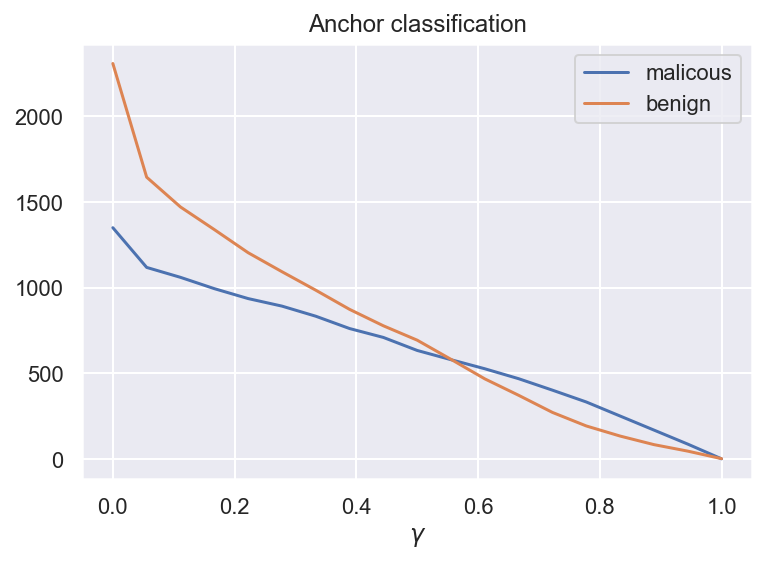

In [50]:
plt.title('Anchor classification')
plt.plot(df.mal_mer, label='malicous')
plt.plot(df.all_mer-df.mal_mer, label='benign')
plt.xlabel(r"$\gamma$")
plt.legend();

## Influence of the training sample size
Based on the previous results we fix the value of $\gamma=0.7$ and train the network on sample size of different size. Additionally, different seeds are used to generate the data set and check the model vairance. 

In [16]:
import glob

dfs = list()
for n in glob.glob('res/ad-?.csv'):
    dfs.append(pd.read_csv(n, index_col=0))

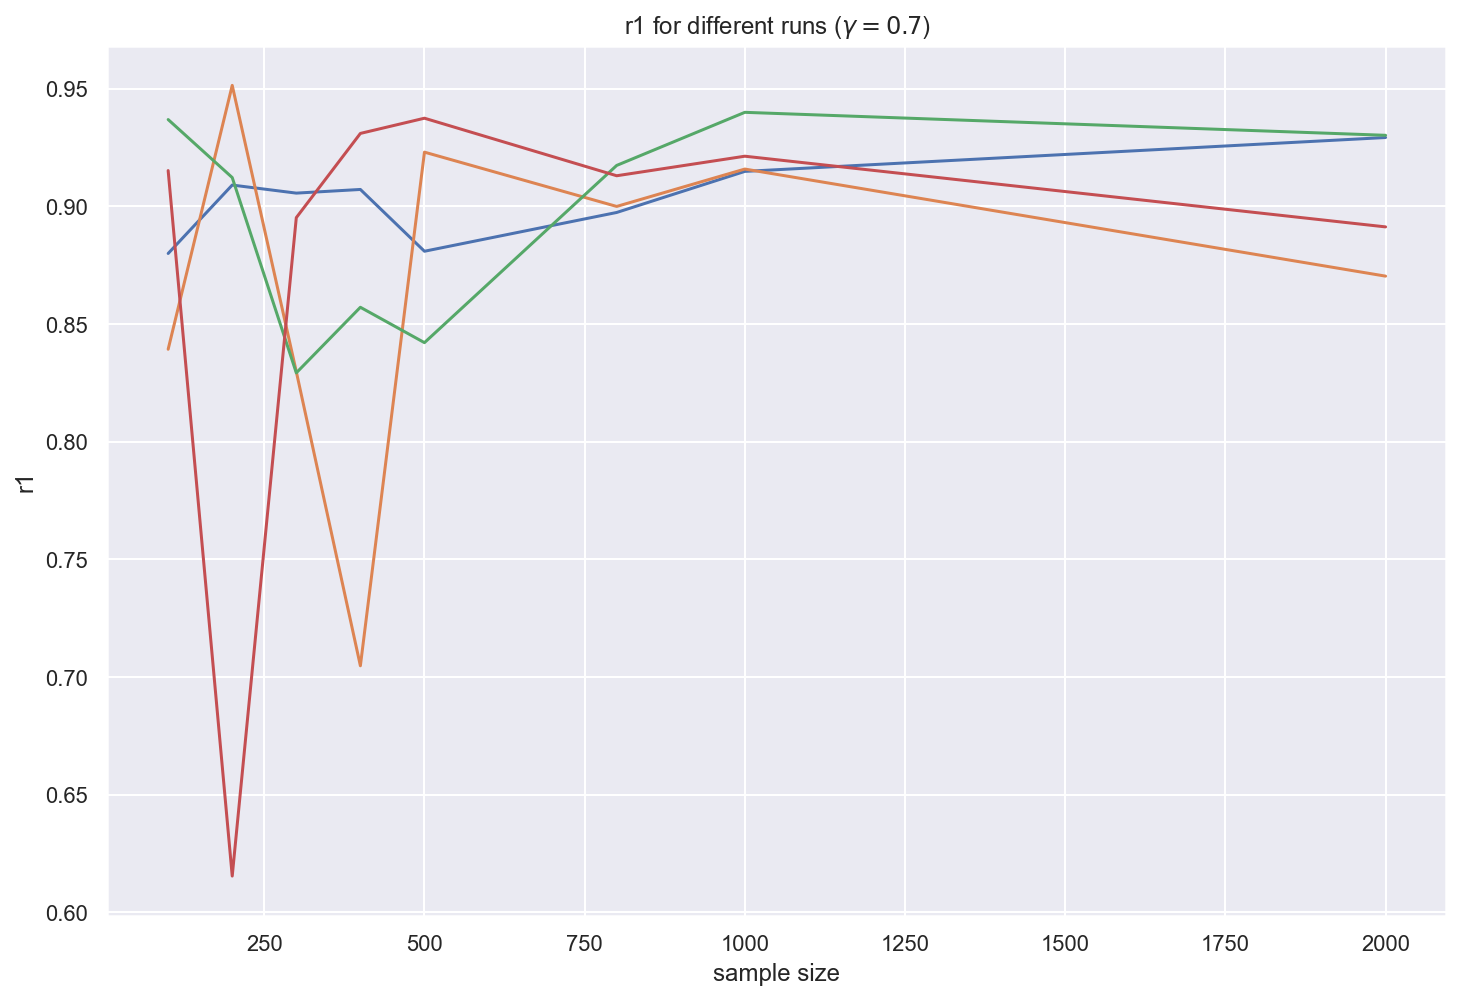

In [17]:
plt.figure(figsize=(12, 8))
plt.title('r1 for different runs ($\gamma=0.7$)')
for e in dfs:
    plt.plot(e.r1)
plt.ylabel('r1')
plt.xlabel('sample size');

## Notes

In [60]:
#0.666667    0.911765
# r-score vs. run time? (moving from right gamma=1.0 to 0, )
# compare performance of small and large data set (only reference?)
# interpreate small model? 
# what-if: chnage features of test to see if the classification chnaged

0.000000    0.971660
0.055556    0.971545
0.111111    0.963415
0.166667    0.965377
0.222222    0.967480
0.277778    0.965377
0.333333    0.963265
0.388889    0.961460
0.444444    0.938614
0.500000    0.948240
0.555556    0.925620
0.611111    0.914761
0.666667    0.911765
Name: r1_mer, dtype: float64